# Analysis of Circadian Oscillator model using MinimallyDisruptiveCurves.jl

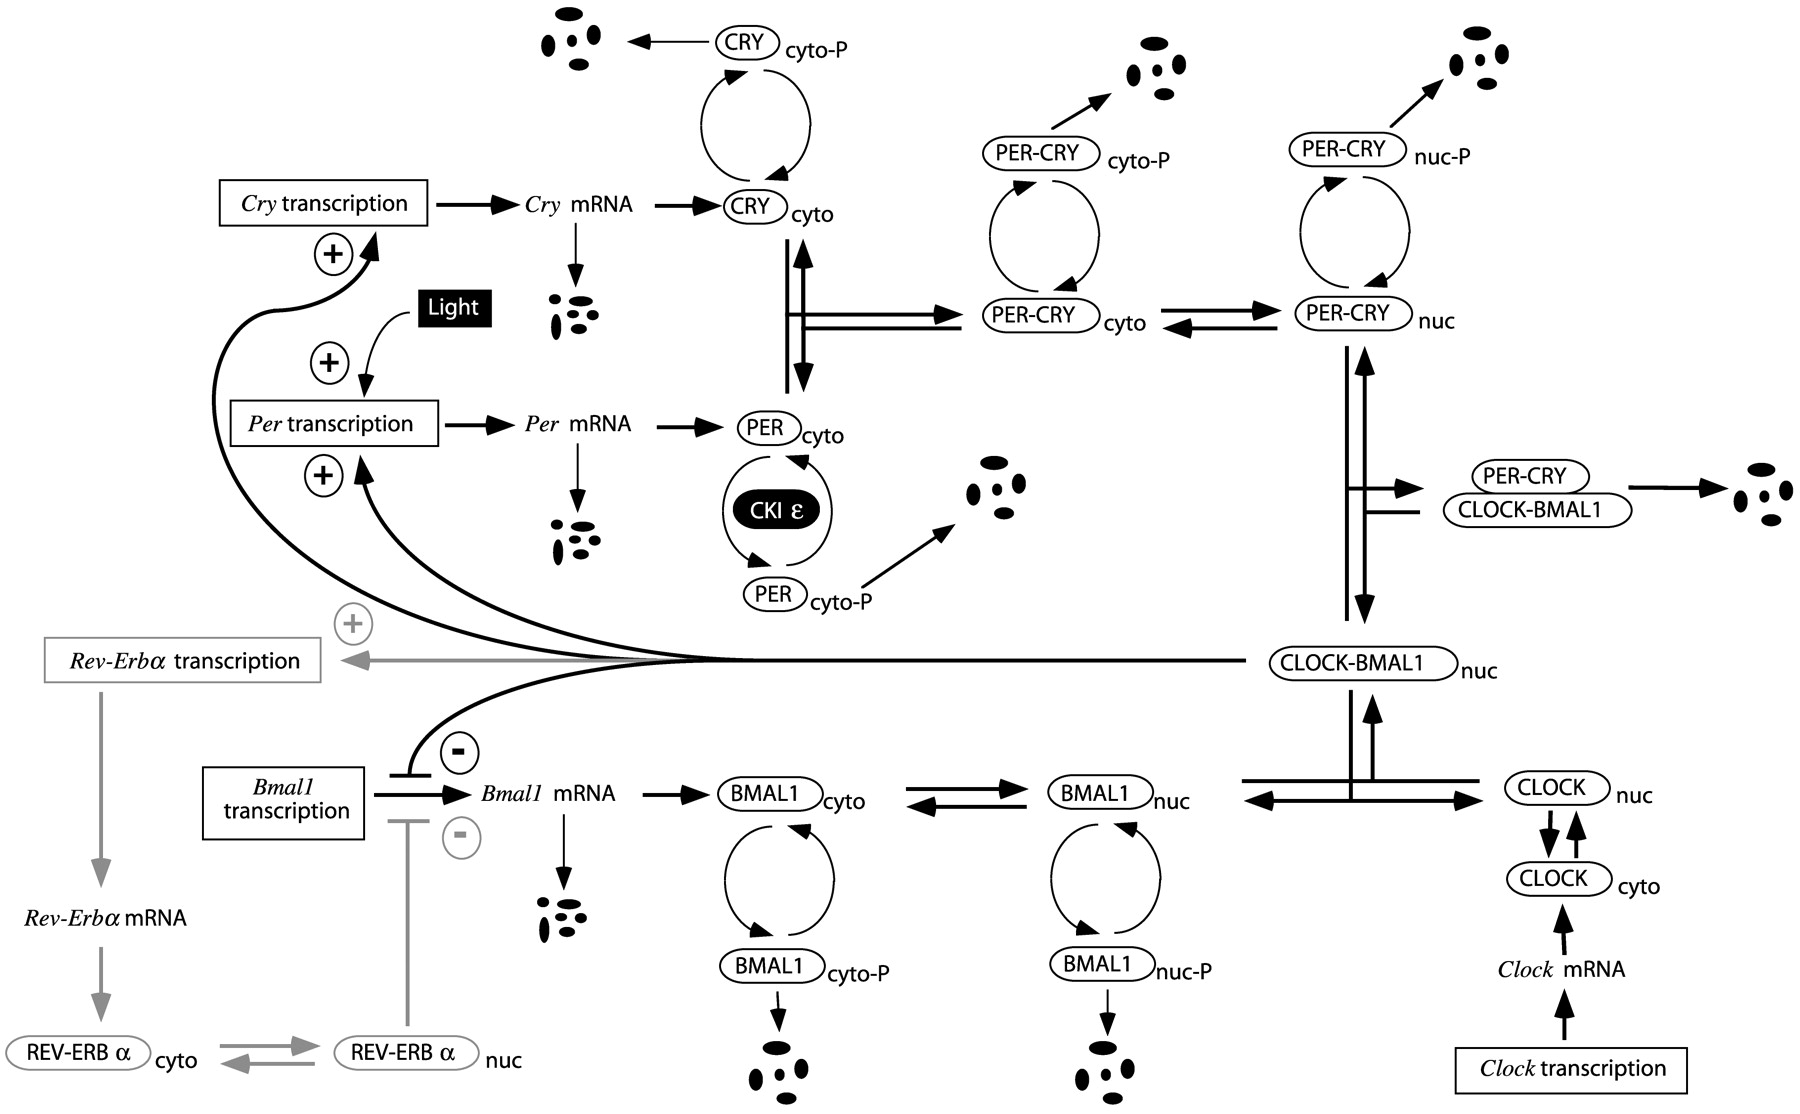

In [ ]:
using MyModelMenagerie, OrdinaryDiffEq, MinimallyDisruptiveCurves, Plots, LinearAlgebra, DiffEqParamEstim, DiffEqSensitivity

In [ ]:
include("helper_functions.jl");
alg = Vern9 #or eg Tsit5, used for solving ODE
solve = OrdinaryDiffEq.solve #because it clashes with JuMP.solve

In [3]:
od,ic,tspan,ps = CircadianOscillator(); #argument is input to the model

default input is t -> 1.5. If CircadianOscillator() is called with no arguments, the default is used


In [4]:
prob = ODEProblem(od,ic,tspan,ps)
# to_fix = ["c2c","c2","c2a","c3c", "c1c", "a2"]
# tstrct_fix = fix_params(last.(ps), get_name_ids(ps, to_fix))
# od, ic, ps = transform_problem(prob,tstrct_fix; unames = first.(ic), pnames = first.(ps))
# prob = ODEProblem(od,ic,tspan,ps)
# tstrct_log = logabs_transform(last.(ps))
# od, ic, ps = transform_problem(prob, tstrct_log; unames=first.(ic), pnames = first.(ps))
# prob = ODEProblem(od,ic,tspan,ps);
# p0 = last.(ps);

In [5]:
nom_sol = solve(prob, alg())
tsteps = nom_sol.t
## make loss function: l2 difference between trajectories of parameter-varying and nominal (fixed) solution, over all states.S
integrand(el1, el2) = sum(abs2, el1 - el2)
lossf(sol, nom_sol) = sum( integrand(el1,el2) for (el1,el2) in zip(eachcol(sol), eachcol(nom_sol)  )  )
lossf1(sol) = lossf(sol, nom_sol);

In [ ]:
plot(nom_sol)

In [11]:
cost = build_injection_loss(prob, Tsit5(), tsteps);
using ForwardDiff
p0 = prob.p
hess = ForwardDiff.hessian(cost, p0)
hess = Symmetric(hess);

In [ ]:
potential_dirs = [sparse_init_dir(hess)[1] for i = 1:100]
pd_projs = [el'*hess*el for el in potential_dirs]; # ie how good is each guess
inds = sortperm(pd_projs) # sort in order
potential_dirs = potential_dirs[inds];

In [15]:
duplicates = [] # remove potential_directions that are approximately equal (norm(a-b) < 1e-5) to previous directions
for (i,el) in enumerate(potential_dirs)
    for (j,comp) in enumerate(potential_dirs[i+1:end])
        if ((norm(el - comp) < 1e-5) || (norm(el + comp) < 1e-1))
            push!(duplicates, i+j)
        end
    end  
end
potential_dirs[unique(duplicates)]
potential_dirs = potential_dirs[setdiff(1:length(potential_dirs), duplicates)];

In [ ]:
function get_plot(dirnum)
    dp0 = potential_dirs[dirnum]
    mom = 1.
    span = (-10.,10.)
    eprob = MDCProblem(cost, p0, dp0, mom, span);  
    @time mdc = evolve(eprob, Tsit5);
    p = disp_mdc(mdc,ps)
    #savefig(p, "CircadianInjectionMDC_$(dirnum).png")
end

In [ ]:
for i = 1:length(potential_dirs)
   get_plot(i) 
end

### Minimally disruptive curves

- I plotted the first ten using this code.
- I haven't interpreted them.
- The first 5 are below. The others are in the folder: circadian_pics (didn't want to make this ipynb file too large)

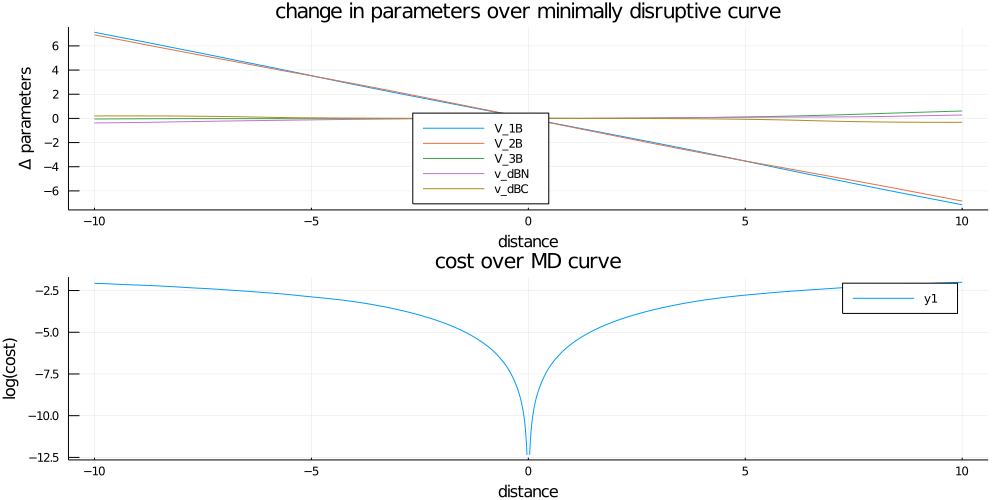
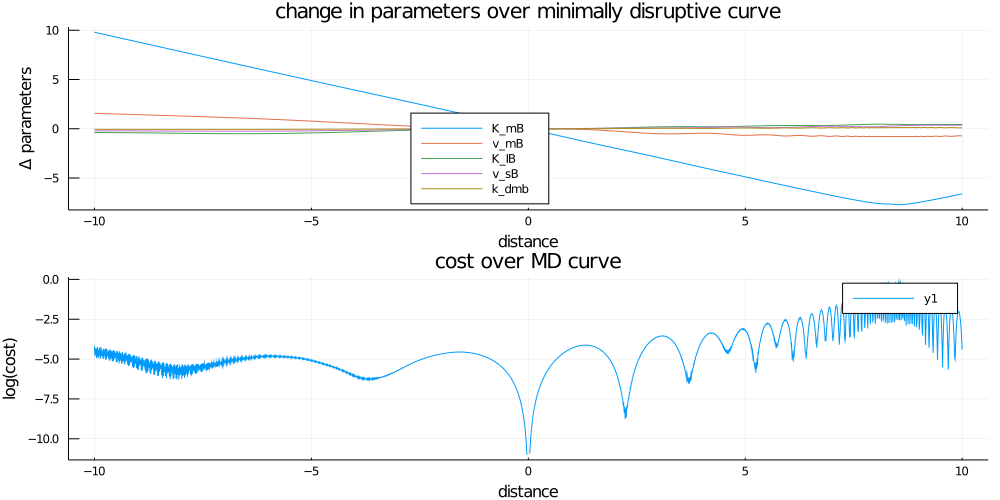
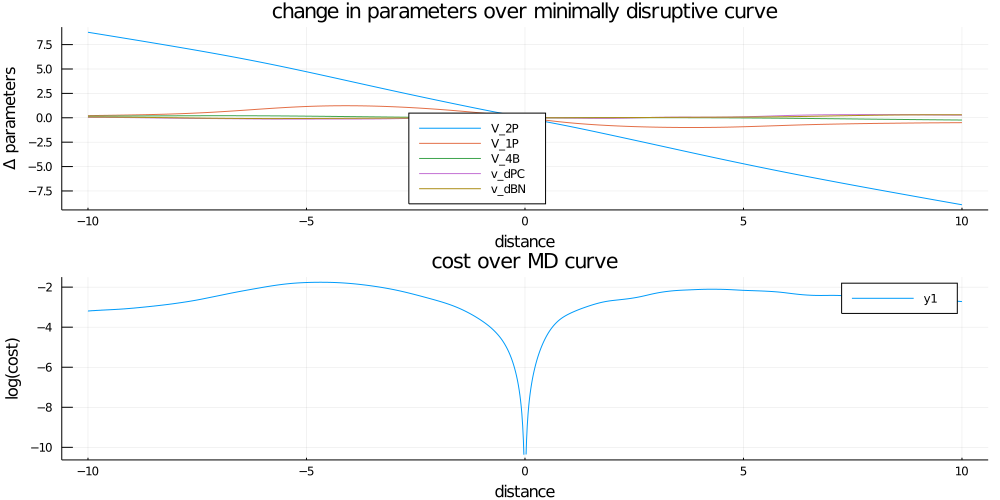

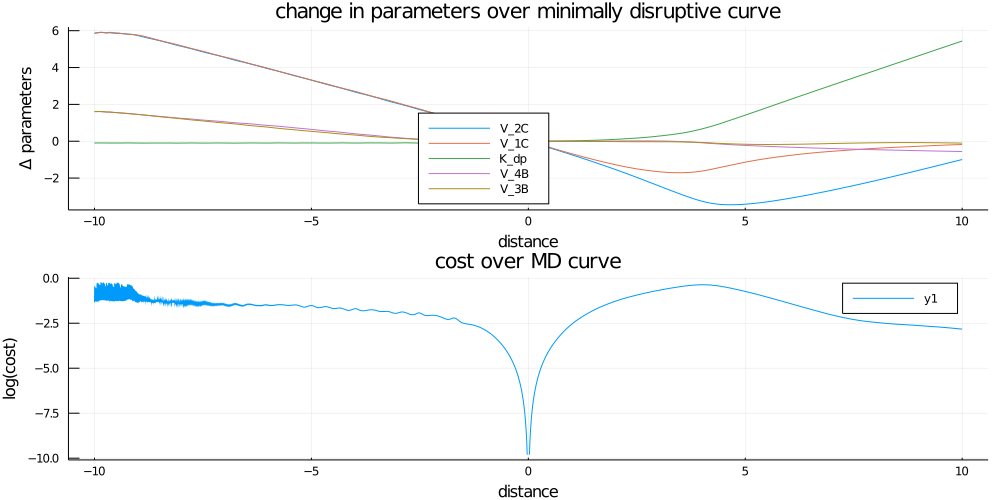
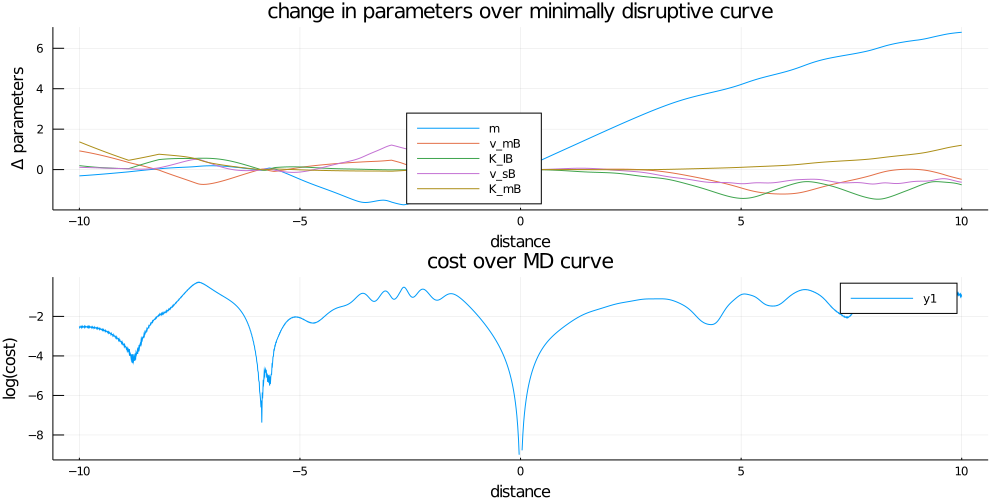